In [ ]:
# Libraries
import os
from shutil import unpack_archive

import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.layers import Dropout
import tensorflow as tf

from itertools import combinations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Dataset/PROA/Project Assignment/
%cd pyvenn

/content/drive/MyDrive/Dataset/PROA/Project Assignment
/content/drive/MyDrive/Dataset/PROA/Project Assignment/pyvenn


In [ ]:
import matplotlib.pyplot as plt
import venn

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Dataset/PROA/Project Assignment/fintech_banking_dataset/train.csv", sep = ';')

In [ ]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Data sudah bersih dari null value dan siap untuk preprocessing selanjutnya, namun terdapat beberapa field yang berupa object dan kita harus mengubahnya menjadi integer 

Cek field yang berupa object

In [ ]:
idx_obj = []
num = 0
for w in list(df_train.dtypes):
  if str(w) == 'object':
    idx_obj.append(num)
  num = num+1

col_obj = []
for i in idx_obj:
  num = int(i)
  print(df_train.iloc[:,num].name)
  col_obj.append(df_train.iloc[:,num].name)
  print(df_train.iloc[:,num].unique(),'\n')

job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student'] 

marital
['married' 'single' 'divorced'] 

education
['tertiary' 'secondary' 'unknown' 'primary'] 

default
['no' 'yes'] 

housing
['yes' 'no'] 

loan
['no' 'yes'] 

contact
['unknown' 'cellular' 'telephone'] 

month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'] 

poutcome
['unknown' 'failure' 'other' 'success'] 

y
['no' 'yes'] 



Ubah data berupa object menjadi urutan angka dengan decoder

In [ ]:
def OHE(dt):
  un = set(dt)
  data_to_int = dict((c, i) for i, c in enumerate(un))
  print(data_to_int)
  integer_encoded = [data_to_int[x] for x in dt]
  return integer_encoded, data_to_int

Apply semua field bertipe object ke decoder

In [ ]:
#encode and drop the previous field
list_OHE = []
for obj in col_obj:
  ob = str(obj)
  name = ob+'_OHE'
  print(name)
  df_train[name] = OHE(list(df_train[ob]))[0]
  list_OHE.append(OHE(list(df_train[ob]))[1])
  #df_train = df_train.drop(labels=ob, axis=1)

job_OHE
{'technician': 0, 'unemployed': 1, 'blue-collar': 2, 'admin.': 3, 'housemaid': 4, 'management': 5, 'self-employed': 6, 'entrepreneur': 7, 'student': 8, 'unknown': 9, 'services': 10, 'retired': 11}
{'technician': 0, 'unemployed': 1, 'blue-collar': 2, 'admin.': 3, 'housemaid': 4, 'management': 5, 'self-employed': 6, 'entrepreneur': 7, 'student': 8, 'unknown': 9, 'services': 10, 'retired': 11}
marital_OHE
{'married': 0, 'single': 1, 'divorced': 2}
{'married': 0, 'single': 1, 'divorced': 2}
education_OHE
{'primary': 0, 'secondary': 1, 'tertiary': 2, 'unknown': 3}
{'primary': 0, 'secondary': 1, 'tertiary': 2, 'unknown': 3}
default_OHE
{'yes': 0, 'no': 1}
{'yes': 0, 'no': 1}
housing_OHE
{'yes': 0, 'no': 1}
{'yes': 0, 'no': 1}
loan_OHE
{'yes': 0, 'no': 1}
{'yes': 0, 'no': 1}
contact_OHE
{'cellular': 0, 'unknown': 1, 'telephone': 2}
{'cellular': 0, 'unknown': 1, 'telephone': 2}
month_OHE
{'jul': 0, 'feb': 1, 'sep': 2, 'aug': 3, 'mar': 4, 'jan': 5, 'may': 6, 'apr': 7, 'jun': 8, 'oct': 9

Dari sini kita dapat melihat bahwa kategori unknown/sumber tidak yang diketahui berasal dari 4 kategori yaitu kontak, hasil kampanye sebelumnya (poutcome), edukasi, dan pekerjaan

Melihat korelasi untuk menentukan arah hubungan setiap field

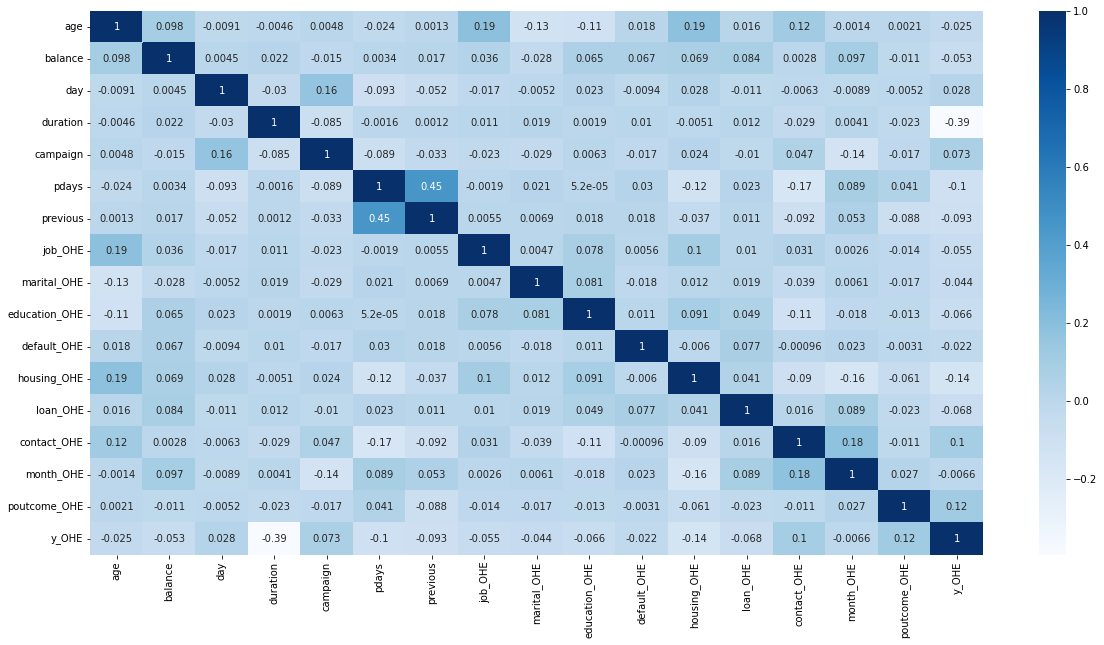

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(df_train.corr(), annot=True,cmap="Blues")

Beberapa sumber tidak diketahui/unknown 

Nasabah yang memiliki KPR memiliki keterhubungan negatif paling besar terhadap hasil kampanye, artinya semakin nasabah tidak memiliki KPR semakin besar kecenderungan untuk mengiyakan kampanye. 

Sebaliknya, semakin besar banyak/lama kontak yang dilakukan tim telemarketing, semakin besar kecenderungan untuk mengiyakan kampanye

In [ ]:
#all comb
key_comb = []
sum_comb = []
index = []

key_comb.append("all")
index.append(df_train.loc[(df_train['job']=='unknown') & (df_train['education']=='unknown') & (df_train['contact']=='unknown') & (df_train['poutcome']=='unknown')].index)
print(len(df_train.loc[(df_train['job']=='unknown') & (df_train['education']=='unknown') & (df_train['contact']=='unknown') & (df_train['poutcome']=='unknown')]))
sum_comb.append(len(df_train.loc[(df_train['job']=='unknown') & (df_train['education']=='unknown') & (df_train['contact']=='unknown') & (df_train['poutcome']=='unknown')]))
idx = [k for k in df_train.loc[(df_train['job']=='unknown') & (df_train['education']=='unknown') & (df_train['contact']=='unknown') & (df_train['poutcome']=='unknown')].index]
idx_s = set(idx)
idx = list(idx_s)

#comb 3
comb = combinations(['job', 'education', 'contact', 'poutcome'], 3)
for i in list(comb):
  print(str(i[0]),"and",str(i[1]),"and",str(i[2]))
  labels_ = str(i[0])+" and "+str(i[1])+" and "+str(i[2])
  key_comb.append(labels_)
  index.append([k for k in df_train.loc[(df_train[str(i[0])]=='unknown') & (df_train[str(i[1])]=='unknown') & (df_train[str(i[2])]=='unknown')].index if k not in idx])
  sum_ = len([k for k in df_train.loc[(df_train[str(i[0])]=='unknown') & (df_train[str(i[1])]=='unknown') & (df_train[str(i[2])]=='unknown')].index if k not in idx])
  print(sum_)
  sum_comb.append(sum_)
  for j in df_train.loc[(df_train[str(i[0])]=='unknown') & (df_train[str(i[1])]=='unknown') & (df_train[str(i[2])]=='unknown')].index:
    idx.append(j)
  idx_s = set(idx)
  idx = list(idx_s)

#comb 2
comb = combinations(['job', 'education', 'contact', 'poutcome'], 2)
for i in list(comb):
  print(str(i[0]),"and",str(i[1]))
  labels_ = str(i[0])+" and "+str(i[1])
  key_comb.append(labels_)
  index.append([k for k in df_train.loc[(df_train[str(i[0])]=='unknown') & (df_train[str(i[1])]=='unknown')].index if k not in idx])
  sum_ = len([k for k in df_train.loc[(df_train[str(i[0])]=='unknown') & (df_train[str(i[1])]=='unknown')].index if k not in idx])
  print(sum_)
  sum_comb.append(sum_)
  for j in df_train.loc[(df_train[str(i[0])]=='unknown') & (df_train[str(i[1])]=='unknown')].index:
    idx.append(j)
  idx_s = set(idx)
  idx = list(idx_s)

#comb 1
comb = combinations(['job', 'education', 'contact', 'poutcome'], 1)
labels_ = ""
for i in list(comb):
  print(str(i[0]))
  labels_ = str(i[0])
  key_comb.append(labels_)
  index.append([k for k in df_train.loc[(df_train[str(i[0])]=='unknown')].index if k not in idx])
  sum_ = len([k for k in df_train.loc[(df_train[str(i[0])]=='unknown')].index if k not in idx])
  print(sum_)
  sum_comb.append(sum_)
  for j in df_train.loc[(df_train[str(i[0])]=='unknown')].index:
    idx.append(j)
  idx_s = set(idx)
  idx = list(idx_s)

54
job and education and contact
0
job and education and poutcome
62
job and contact and poutcome
57
education and contact and poutcome
618
job and education
11
job and contact
0
job and poutcome
82
education and contact
5
education and poutcome
800
contact and poutcome
12221
job
22
education
307
contact
65
poutcome
23065


In [ ]:
sum_comb_s = [str(i) for i in sum_comb]
labels_l = dict(zip(key_comb,sum_comb_s))
print(labels_l)

{'all': '54', 'job and education and contact': '0', 'job and education and poutcome': '62', 'job and contact and poutcome': '57', 'education and contact and poutcome': '618', 'job and education': '11', 'job and contact': '0', 'job and poutcome': '82', 'education and contact': '5', 'education and poutcome': '800', 'contact and poutcome': '12221', 'job': '22', 'education': '307', 'contact': '65', 'poutcome': '23065'}


'0001': poutcome, 
'0011': contact x poutcome, 
'0010': contact, 
'0100': education, 
'0101': education x poutcome, 
'0110': education x contact, 
'0111': education x contact x poutcome,
 '1000': job, 
'1001': job x poutcome, 
'1010': job x contact, 
'1011': job x contact x poutcome, 
'1100': job x education,
 '1101': job x education x poutcome, 
'1110': job x education x contact,
 '1111': all

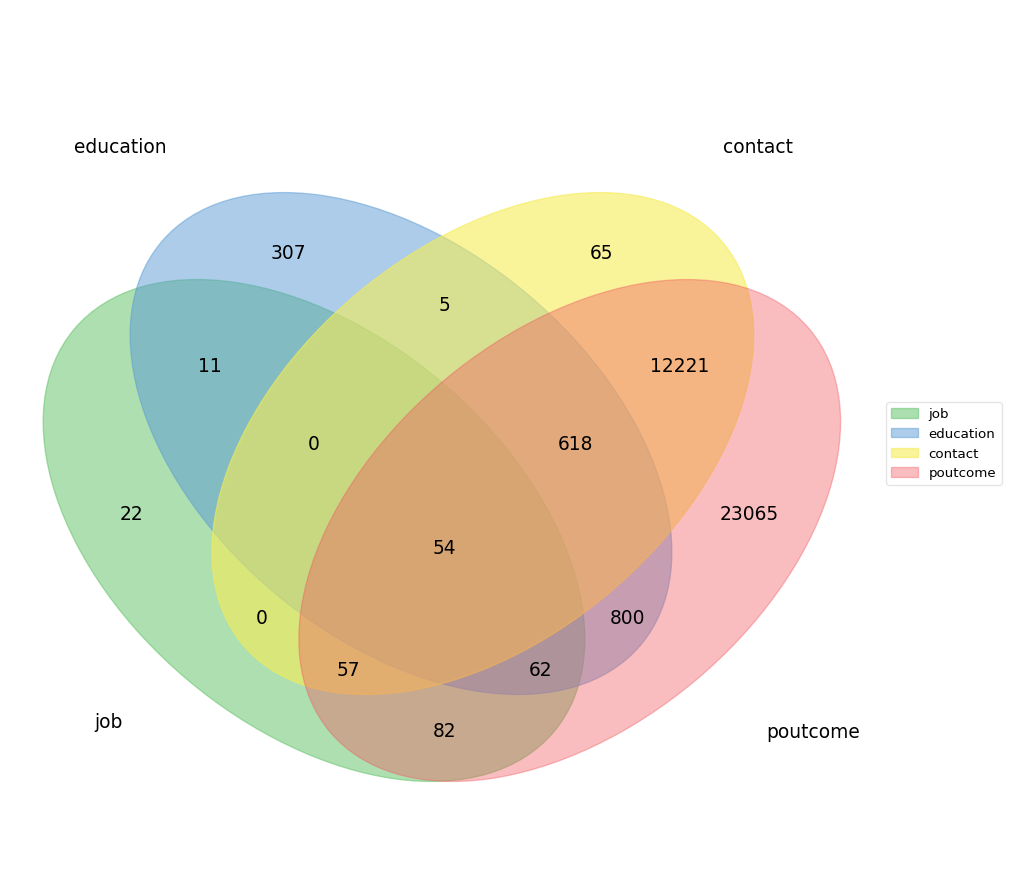

In [ ]:
labels = venn.get_labels([range(10), range(5, 15), range(3, 8), range(8, 17)], fill=['number'])
labels['0001'] = sum_comb_s[14]
labels['0010'] = sum_comb_s[13]
labels['0011'] = sum_comb_s[10]
labels['0100'] = sum_comb_s[12]
labels['0101'] = sum_comb_s[9]
labels['0110'] = sum_comb_s[8]
labels['0111'] = sum_comb_s[4]
labels['1000'] = sum_comb_s[11]
labels['1001'] = sum_comb_s[7]
labels['1010'] = sum_comb_s[6]
labels['1011'] = sum_comb_s[3]
labels['1100'] = sum_comb_s[5]
labels['1101'] = sum_comb_s[2]
labels['1110'] = sum_comb_s[1]
labels['1111'] = sum_comb_s[0]

fig, ax = venn.venn4(labels, names=['job', 'education', 'contact', 'poutcome'])
fig.show()

In [ ]:
len(df_train.loc[(df_train['job']=='unknown') | (df_train['education']=='unknown') | (df_train['contact']=='unknown') | (df_train['poutcome']=='unknown')])

37369

In [ ]:
percentage = len(idx)/len(df_train)*100
print("Sebanyak",len(idx),"rows terdapat unknown source atau",percentage,'% total dataset train')

Sebanyak 37369 rows terdapat unknown source atau 82.65466368804051 % total dataset train


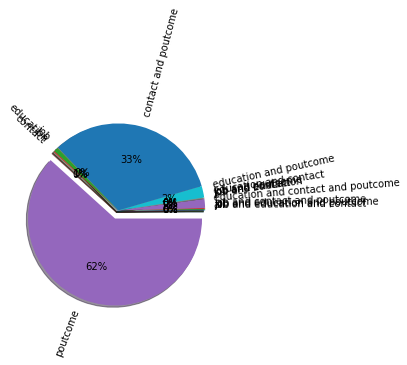

<Figure size 3600x3600 with 0 Axes>

In [ ]:
# declaring data
data = sum_comb
keys = key_comb
  
# declaring exploding pie
explode = []
for i in range(len(data)):
  if i == 14:
    explode.append(0.1)
  else:
    explode.append(0)
palette_color = sns.color_palette('bright')
  
# plotting data on chart
plt.pie(data, labels=keys, 
        explode=explode, autopct='%.0f%%',  shadow=True, rotatelabels='true')
  
# displaying chart
fig = plt.figure()
fig.set_size_inches(50, 50)
plt.show()

Jumlah yang terbesar pada field dengan value "unknown" adalah hasil kampanye sebelumnya(poutcome), disusul dengan irisan antara kontak dan hasil kampanye sebelumnya. Dua field tersebut menyumbang 95% dari total kombinasi "unknown". Maka dari itu rows dengan kombinasi lainnya akan dihapus

In [ ]:
removed_index = set()
for i in range(len(index)):
  if i != 14 and i != 10:
    for j in index[i]:
      removed_index.add(j)
df_train_w = df_train.copy()
df_train_w.drop(list(removed_index), inplace=True)

Hanya 5% dari unknown source yang dihapus yaitu selain dua kombinasi teratas value unknown

In [ ]:
for obj in col_obj:
  ob = str(obj)
  name = ob+'_OHE'
  print(name)
  df_train_w = df_train_w.drop(labels=ob, axis=1)

job_OHE
marital_OHE
education_OHE
default_OHE
housing_OHE
loan_OHE
contact_OHE
month_OHE
poutcome_OHE
y_OHE


In [ ]:
df_train_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43128 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            43128 non-null  int64
 1   balance        43128 non-null  int64
 2   day            43128 non-null  int64
 3   duration       43128 non-null  int64
 4   campaign       43128 non-null  int64
 5   pdays          43128 non-null  int64
 6   previous       43128 non-null  int64
 7   job_OHE        43128 non-null  int64
 8   marital_OHE    43128 non-null  int64
 9   education_OHE  43128 non-null  int64
 10  default_OHE    43128 non-null  int64
 11  housing_OHE    43128 non-null  int64
 12  loan_OHE       43128 non-null  int64
 13  contact_OHE    43128 non-null  int64
 14  month_OHE      43128 non-null  int64
 15  poutcome_OHE   43128 non-null  int64
 16  y_OHE          43128 non-null  int64
dtypes: int64(17)
memory usage: 5.9 MB


Setelah dicek kembali pdays valuenya tidak sesuai karena terdapat negative value

In [ ]:
df_train_w['pdays'] = df_train_w['pdays'].apply(lambda x: x*-1 if x<0 else x)
df_train_w['balance'] = df_train_w['balance'].apply(lambda x: 0 if x<0 else x)

Sekarang cek outlier dengan boxplot

In [ ]:
df_train_boxplot = df_train_w.copy()
for obj in col_obj:
  ob = str(obj)
  name = ob+'_OHE'
  df_train_boxplot = df_train_boxplot.drop(labels=name, axis=1)

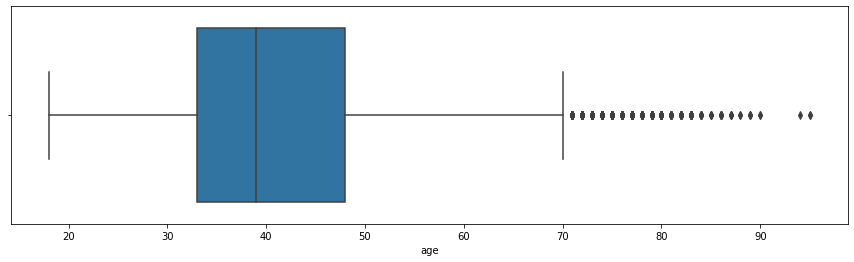

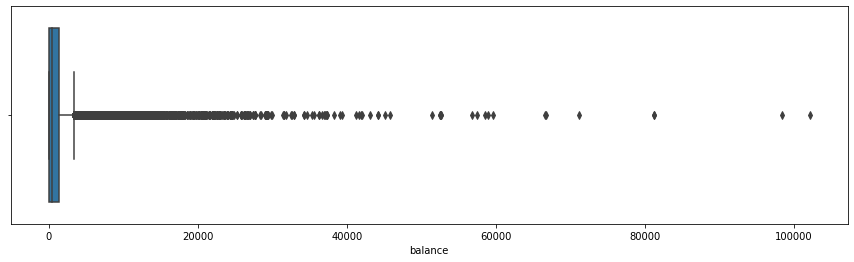

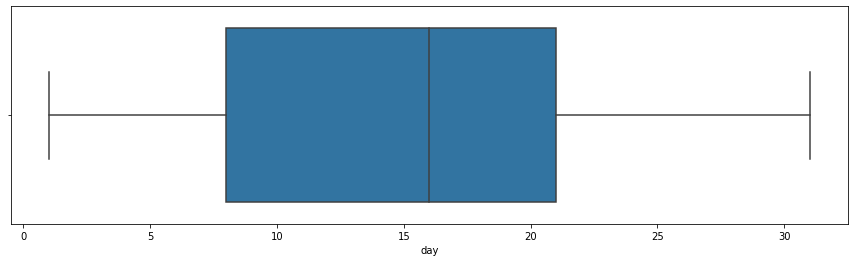

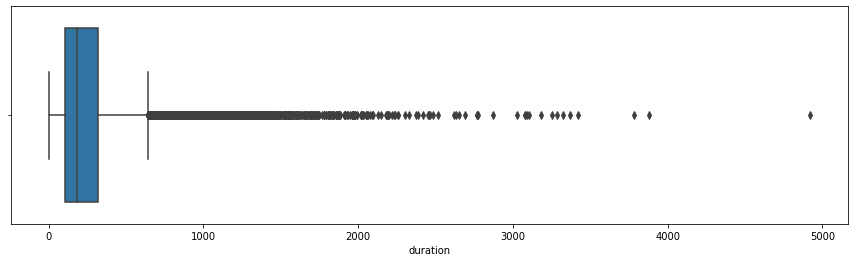

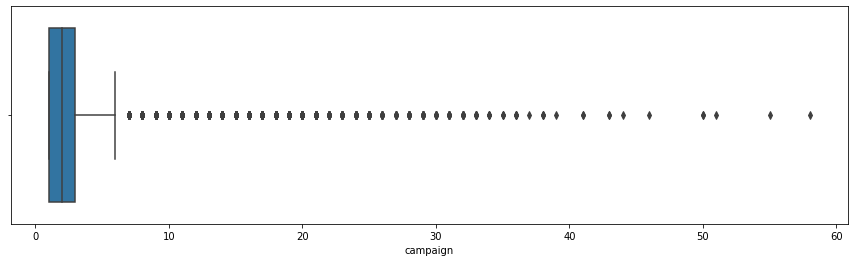

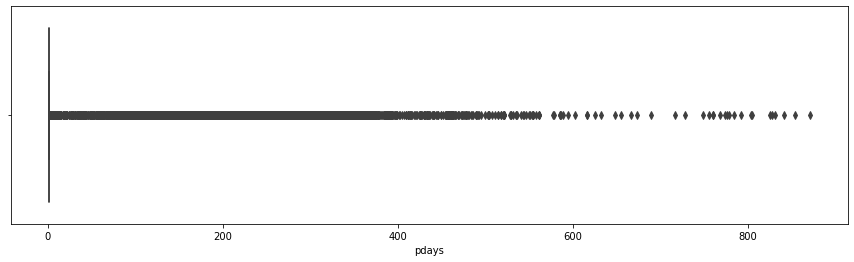

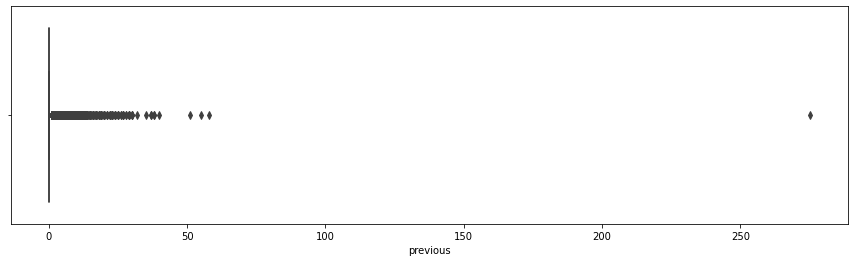

In [ ]:
for col in range(len(df_train_boxplot.columns)):
  if col%1 == 0:
    f, axes = plt.subplots(ncols=1, figsize=(15,4))
    sns.boxplot(x=df_train_boxplot.iloc[:,col].name,data=df_train_boxplot)
    plt.show()

Semua field dengan value kontinyu memiliki outlier atas yang besar

In [ ]:
def removal(dt):
  q1 = np.quantile(dt,0.25)
  q3 = np.quantile(dt,0.75)
  iqr = 1.5*(q3-q1)
  low_out, up_out = q1-iqr,q3+iqr
  return low_out,up_out

In [ ]:
for i in df_train_boxplot.columns:
  lw,up = removal(df_train_boxplot[str(i)])
  print(i,":",len(df_train_boxplot[str(i)].loc[(df_train_boxplot[str(i)]<lw) | (df_train_boxplot[str(i)]>up)]))

age : 434
balance : 4520
day : 0
duration : 3087
campaign : 2899
pdays : 7833
previous : 7847


previous dan pdays memiliki outlier yang paling banyak

Karena outlier jumlahnya cukup besar maka kita akan handling dengan replace value dengan median daripada didrop karena jumlah dataset yang terbatas

In [ ]:
lw_list = []
up_list = []
median_list = []
for i in df_train_boxplot.columns:
  lw,up = removal(df_train_boxplot[str(i)])
  lw_list.append(lw)
  up_list.append(up)
  print(i,lw,up)
  median = np.median(df_train_boxplot[str(i)])
  median_list.append(median)
  print(str(i),':',median,'\n')
  df_train_boxplot[str(i)] = df_train_boxplot[str(i)].apply(lambda x: median if x<lw or x>up else x)

age 10.5 70.5
age : 39.0 

balance -1941.5 3424.5
balance : 442.0 

day -11.5 40.5
day : 16.0 

duration -221.0 643.0
duration : 180.0 

campaign -2.0 6.0
campaign : 2.0 

pdays 1.0 1.0
pdays : 1.0 

previous 0.0 0.0
previous : 0.0 



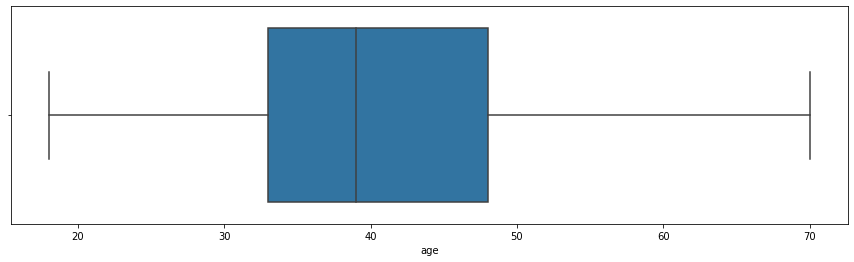

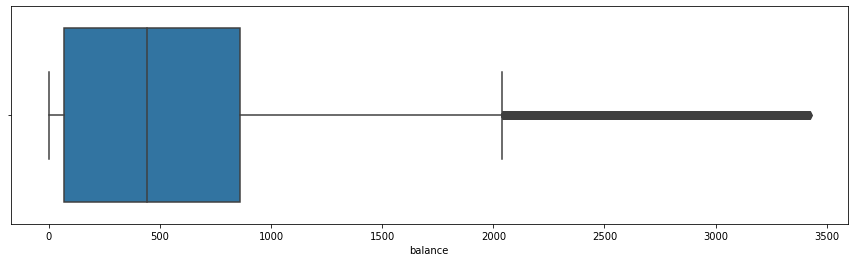

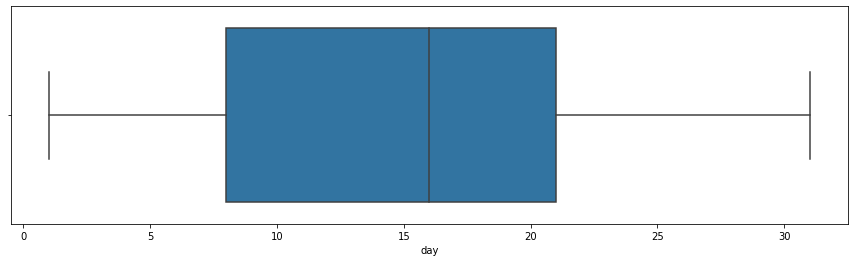

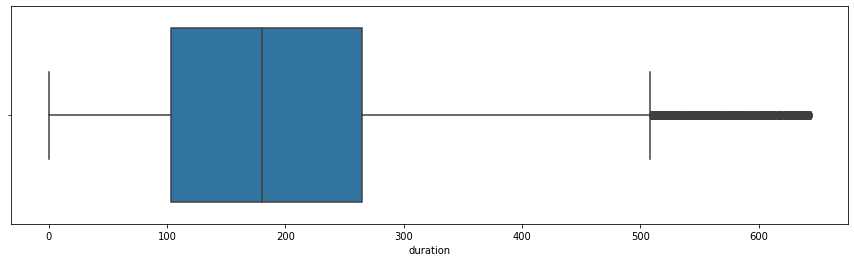

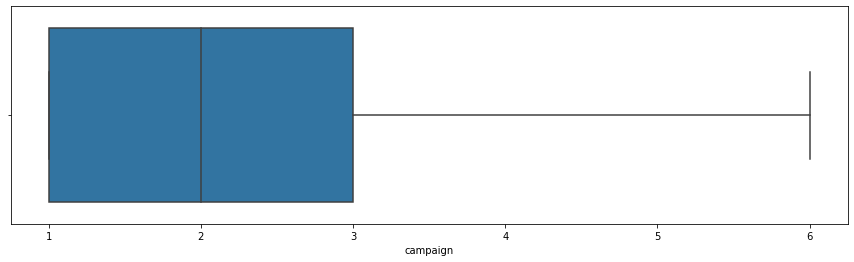

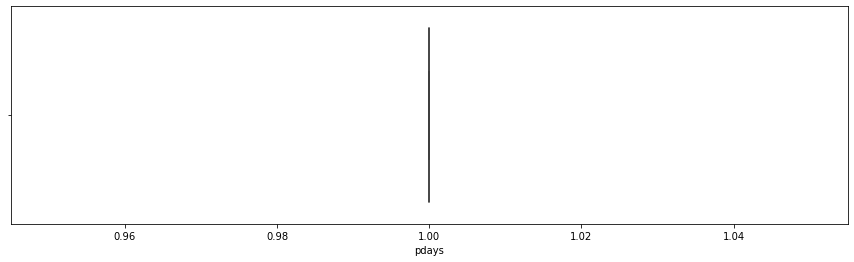

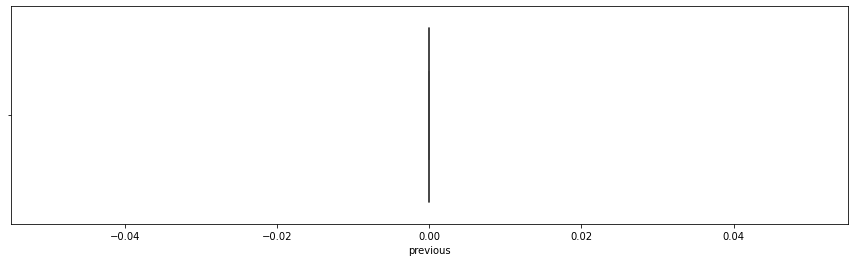

In [ ]:
for col in range(len(df_train_boxplot.columns)):
  if col%1 == 0:
    f, axes = plt.subplots(ncols=1, figsize=(15,4))
    sns.boxplot(x=df_train_boxplot.iloc[:,col].name,data=df_train_boxplot)
    plt.show()

In [ ]:
#jumlah outlier
for i in df_train_boxplot.columns:
  lw,up = removal(df_train_boxplot[str(i)])
  print(i,":",len(df_train_boxplot[str(i)].loc[(df_train_boxplot[str(i)]<lw) | (df_train_boxplot[str(i)]>up)]))

age : 0
balance : 3381
day : 0
duration : 1897
campaign : 0
pdays : 0
previous : 0


Outlier berkurang secara signifikan

Hilangkan sisanya

In [ ]:
outlier_index = set()
for i in df_train_boxplot.columns:
  lw,up = removal(df_train_boxplot[str(i)])
  for j in df_train_boxplot[str(i)].loc[(df_train_boxplot[str(i)]<lw) | (df_train_boxplot[str(i)]>up)].index:
    outlier_index.add(int(j))

In [ ]:
for i in df_train_boxplot.columns:
  title = str(i)+"_outlier"
  df_train_w[title] = df_train_boxplot[str(i)]

In [ ]:
df_train_w.drop(outlier_index, inplace=True)

In [ ]:
df_train_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38014 entries, 1 to 45209
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               38014 non-null  int64  
 1   balance           38014 non-null  int64  
 2   day               38014 non-null  int64  
 3   duration          38014 non-null  int64  
 4   campaign          38014 non-null  int64  
 5   pdays             38014 non-null  int64  
 6   previous          38014 non-null  int64  
 7   job_OHE           38014 non-null  int64  
 8   marital_OHE       38014 non-null  int64  
 9   education_OHE     38014 non-null  int64  
 10  default_OHE       38014 non-null  int64  
 11  housing_OHE       38014 non-null  int64  
 12  loan_OHE          38014 non-null  int64  
 13  contact_OHE       38014 non-null  int64  
 14  month_OHE         38014 non-null  int64  
 15  poutcome_OHE      38014 non-null  int64  
 16  y_OHE             38014 non-null  int64 

Agar model yang dihasilkan realistis Durasi tidak dibawa dalam pemodelan

In [ ]:
# X = df_train_w[["age_outlier", "job_OHE", "marital_OHE", "education_OHE", "default_OHE", "balance_outlier", "housing_OHE", "loan_OHE", "contact_OHE", "day_outlier", "month_OHE", "duration_outlier", "campaign_outlier", "previous_outlier", "poutcome_OHE"]]
# y = df_train_w['y_OHE']
X = df_train_w[["age_outlier", "job_OHE", "marital_OHE", "education_OHE", "default_OHE", "balance_outlier", "housing_OHE", "loan_OHE", "contact_OHE", "day_outlier", "month_OHE", "campaign_outlier", "previous_outlier", "poutcome_OHE"]]
y = df_train_w['y_OHE']

Split data train dan data validasi

Gunakan annova untuk best selection karena terdapat negative value pada field balance

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Feature 0 age_outlier : 10.617863936408146
Feature 1 job_OHE : 65.0600611889903
Feature 2 marital_OHE : 53.68504277556971
Feature 3 education_OHE : 143.57855233483772
Feature 4 default_OHE : 23.23510112440749
Feature 5 balance_outlier : 149.12410706960824
Feature 6 housing_OHE : 553.0576137550341
Feature 7 loan_OHE : 133.5515396105598
Feature 8 contact_OHE : 289.94810160372583
Feature 9 day_outlier : 25.697102950344675
Feature 10 month_OHE : 2.1863709354245016
Feature 11 campaign_outlier : 112.22910015971522
Feature 12 previous_outlier : nan
Feature 13 poutcome_OHE : 400.3660768202948


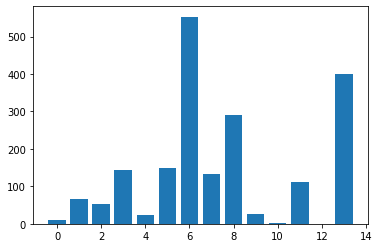

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature',i,X_train.columns[i],':',fs.scores_[i])
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Dari chart diatas membuktikan bahwa kepemilikan KPR, tipe komunikasi memiliki dampak yang besar

In [ ]:
def count(df_):
  cnt = df_.value_counts()
  cnt = dict(cnt)
  return cnt

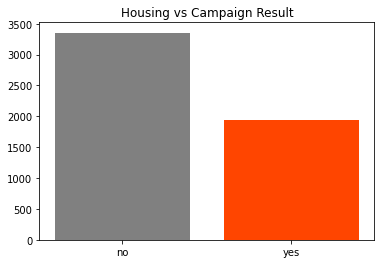

In [ ]:
# Visualize classes counts
res = count(df_train["housing"].loc[(df_train['y']=='yes')])
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])
plt.bar(res.keys(),res.values(),color=colors)
plt.title("Housing vs Campaign Result")
plt.show()

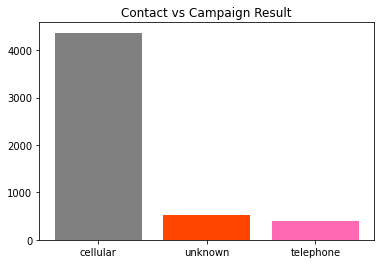

In [ ]:
# Visualize classes counts
res = count(df_train["contact"].loc[(df_train['y']=='yes')])
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])
plt.bar(res.keys(),res.values(),color=colors)
plt.title("Contact vs Campaign Result")
plt.show()

No handles with labels found to put in legend.


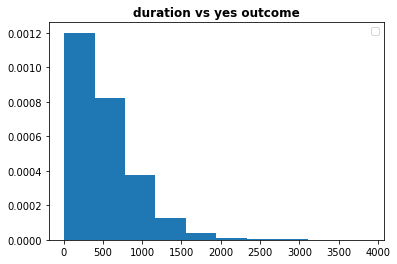

In [ ]:
n_bins = 10
  
plt.hist(df_train["duration"].loc[(df_train['y']=='yes')], n_bins, density = True, 
         histtype ='bar')
  
plt.legend(prop ={'size': 10})
  
plt.title('duration vs yes outcome',
          fontweight ="bold")
  
plt.show()

Dari sini dapat disimpulkan dalam telemarketing penggunaan cellular lebih efektif daripada telefon, tidak memiliki KPR cenderung mengiyakan kampanye ini, dan durasi dibawah 500 detik memiliki efektifitas yang cenderung tinggi

In [ ]:
#seleksi fitur
X_fs = df_train_w[["balance_outlier", "housing_OHE", "contact_OHE", "poutcome_OHE"]]
y_fs = df_train_w['y_OHE']

In [ ]:
# split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_fs, X_val_fs, y_train_fs, y_val_fs = train_test_split(X_fs, y_fs, test_size=0.2, random_state=1)

Modelling menggunakan ANN, karena dataset tidak terlalu kompleks dibandingkan data citra atau gelombang suara

Membandingkan dataset dengan seleksi fitur dan tidak

In [ ]:
#Callback
callback = EarlyStopping(
    monitor="val_accuracy",
    patience=20,
    restore_best_weights=True,
)

In [ ]:
#Early stopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 14))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.0009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = 32, epochs = 50, callbacks=[early_stopping])

Epoch 1/50
951/951 [==============================] - 4s 3ms/step - loss: 0.3956 - accuracy: 0.8955 - val_loss: 0.3264 - val_accuracy: 0.8982
Epoch 2/50
951/951 [==============================] - 3s 3ms/step - loss: 0.3546 - accuracy: 0.8959 - val_loss: 0.3224 - val_accuracy: 0.8982
Epoch 3/50
951/951 [==============================] - 3s 3ms/step - loss: 0.3426 - accuracy: 0.8959 - val_loss: 0.3210 - val_accuracy: 0.8982
Epoch 4/50
951/951 [==============================] - 3s 3ms/step - loss: 0.3347 - accuracy: 0.8959 - val_loss: 0.3216 - val_accuracy: 0.8982
Epoch 5/50
951/951 [==============================] - 3s 3ms/step - loss: 0.3277 - accuracy: 0.8959 - val_loss: 0.3146 - val_accuracy: 0.8982
Epoch 6/50
951/951 [==============================] - 3s 3ms/step - loss: 0.3255 - accuracy: 0.8959 - val_loss: 0.3153 - val_accuracy: 0.8982
Epoch 7/50
951/951 [==============================] - 3s 3ms/step - loss: 0.3232 - accuracy: 0.8959 - val_loss: 0.3137 - val_accuracy: 0.8982
Epoch 

In [ ]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(Dense(16, input_dim=14, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
# Fit the model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=64,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
476/476 [==============================] - 2s 3ms/step - loss: 0.5378 - accuracy: 0.8913 - val_loss: 0.3261 - val_accuracy: 0.8982
Epoch 2/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3315 - accuracy: 0.8959 - val_loss: 0.3249 - val_accuracy: 0.8982
Epoch 3/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3333 - accuracy: 0.8959 - val_loss: 0.3292 - val_accuracy: 0.8982
Epoch 4/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3322 - accuracy: 0.8959 - val_loss: 0.3291 - val_accuracy: 0.8982
Epoch 5/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3339 - accuracy: 0.8959 - val_loss: 0.3290 - val_accuracy: 0.8982
Epoch 6/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3339 - accuracy: 0.8959 - val_loss: 0.3298 - val_accuracy: 0.8982
Epoch 7/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3339 - accuracy: 0.8959 - val_loss: 0.3291 - val_accuracy: 0.8982
Epoch 

In [ ]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(Dense(16, input_dim=4, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
# Fit the model
history = model.fit(X_train_fs,
                    y_train_fs,
                    validation_data=(X_val_fs, y_val_fs),
                    verbose=1,
                    batch_size=64,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
476/476 [==============================] - 2s 3ms/step - loss: 0.4679 - accuracy: 0.8931 - val_loss: 0.3250 - val_accuracy: 0.8982
Epoch 2/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3320 - accuracy: 0.8959 - val_loss: 0.3262 - val_accuracy: 0.8982
Epoch 3/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3317 - accuracy: 0.8959 - val_loss: 0.3247 - val_accuracy: 0.8982
Epoch 4/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3319 - accuracy: 0.8959 - val_loss: 0.3242 - val_accuracy: 0.8982
Epoch 5/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3321 - accuracy: 0.8959 - val_loss: 0.3260 - val_accuracy: 0.8982
Epoch 6/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3311 - accuracy: 0.8959 - val_loss: 0.3250 - val_accuracy: 0.8982
Epoch 7/30
476/476 [==============================] - 1s 3ms/step - loss: 0.3328 - accuracy: 0.8959 - val_loss: 0.3267 - val_accuracy: 0.8982
Epoch 

Tidak ada perubahan hasil namun ada reduksi field

In [ ]:
#Callback
callback = EarlyStopping(
    monitor="accuracy",
    patience=3,
    restore_best_weights=True,
)

In [ ]:
from sklearn.model_selection import StratifiedKFold

tf.keras.backend.clear_session()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores = []
for train, test in kfold.split(X_fs, y_fs):
  model = Sequential()
  model.add(Dense(16, input_dim=4, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  adam = Adam(learning_rate=0.05)
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  # Fit the model
  model.fit(X_fs.iloc[train],
                    y_fs.iloc[train],
                    verbose=1,
                    batch_size=64,
                    epochs=30,
                    callbacks=[callback]
                   )
  # evaluate the model
  scores = model.evaluate(X_fs.iloc[test], y_fs.iloc[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
 
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/30
535/535 [==============================] - 2s 2ms/step - loss: 0.6129 - accuracy: 0.8947
Epoch 2/30
535/535 [==============================] - 1s 2ms/step - loss: 0.3315 - accuracy: 0.8964
Epoch 3/30
535/535 [==============================] - 1s 2ms/step - loss: 0.3329 - accuracy: 0.8963
Epoch 4/30
535/535 [==============================] - 1s 2ms/step - loss: 0.3306 - accuracy: 0.8964
Epoch 5/30
535/535 [==============================] - 1s 2ms/step - loss: 0.3307 - accuracy: 0.8964
accuracy: 89.64%
Epoch 1/30
535/535 [==============================] - 2s 2ms/step - loss: 0.7522 - accuracy: 0.8921
Epoch 2/30
535/535 [==============================] - 1s 2ms/step - loss: 0.3310 - accuracy: 0.8964
Epoch 3/30
535/535 [==============================] - 1s 2ms/step - loss: 0.3303 - accuracy: 0.8964
Epoch 4/30
535/535 [==============================] - 1s 2ms/step - loss: 0.3303 - accuracy: 0.8964
Epoch 5/30
535/535 [==============================] - 1s 2ms/step - loss: 0.3307 - 

Hasilnya data tidak overfitting dan siap untuk evaluasi dataset test

Evaluating test dataset

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/Dataset/PROA/Project Assignment/fintech_banking_dataset/test.csv", sep = ';')

In [ ]:
for i in range(len(col_obj)):
  title_ = col_obj[i]+'_OHE'
  df_test[title_] = [list_OHE[i][x] for x in list(df_test[col_obj[i]])]

In [ ]:
df_test['pdays'] = df_test['pdays'].apply(lambda x: x*-1 if x<0 else x)
df_test['balance'] = df_test['balance'].apply(lambda x: 0 if x<0 else x)

In [ ]:
num = 0
for i in df_train_boxplot.columns:
  if i == 'balance' or i == 'duration':
    title = str(i)+"_outlier"
    df_test[title] = df_test[str(i)].apply(lambda x: median_list[num] if x<lw_list[num] or x>up_list[num] else x)
  num+=1


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               4521 non-null   int64  
 1   job               4521 non-null   object 
 2   marital           4521 non-null   object 
 3   education         4521 non-null   object 
 4   default           4521 non-null   object 
 5   balance           4521 non-null   int64  
 6   housing           4521 non-null   object 
 7   loan              4521 non-null   object 
 8   contact           4521 non-null   object 
 9   day               4521 non-null   int64  
 10  month             4521 non-null   object 
 11  duration          4521 non-null   int64  
 12  campaign          4521 non-null   int64  
 13  pdays             4521 non-null   int64  
 14  previous          4521 non-null   int64  
 15  poutcome          4521 non-null   object 
 16  y                 4521 non-null   object 


In [ ]:
X_test = df_test[["balance_outlier", "housing_OHE", "contact_OHE", "poutcome_OHE"]]
y_test = df_test['y_OHE']

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

142/142 [==============================] - 0s 3ms/step - loss: 0.3578 - accuracy: 0.8848
accuracy: 88.48%


Akurasi akhir yang dicapai adalah 88.48%, yang mengindikasikan bahwa model sudah optimal di angka tersebut